In [123]:
import pandas as pd
import torch
import numpy as np

import plotly
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [107]:
df = pd.read_csv('./data/root_cause_analysis.csv')
df

,ID,CPU_LOAD,MEMORY_LOAD,DELAY,ERROR_1000,ERROR_1001,ERROR_1002,ERROR_1003,ROOT_CAUSE
0,1,0,0,0,0,1,0,1,MEMORY
1,2,0,0,0,0,0,0,1,MEMORY
2,3,0,1,1,0,0,1,1,MEMORY
3,4,0,1,0,1,1,0,1,MEMORY
4,5,1,1,0,1,0,1,0,NETWORK_DELAY
...,...,...,...,...,...,...,...,...,...
995,996,0,0,0,0,0,0,1,DATABASE_ISSUE
996,997,0,0,0,1,0,0,0,NETWORK_DELAY
997,998,1,1,1,0,0,0,0,MEMORY
998,999,0,1,1,1,1,0,0,NETWORK_DELAY


In [108]:
df.isna().sum()

ID             0
CPU_LOAD       0
MEMORY_LOAD    0
DELAY          0
ERROR_1000     0
ERROR_1001     0
ERROR_1002     0
ERROR_1003     0
ROOT_CAUSE     0
dtype: int64

In [109]:
df.dtypes

ID              int64
CPU_LOAD        int64
MEMORY_LOAD     int64
DELAY           int64
ERROR_1000      int64
ERROR_1001      int64
ERROR_1002      int64
ERROR_1003      int64
ROOT_CAUSE     object
dtype: object

In [110]:
df['ROOT_CAUSE'].unique()

array(['MEMORY', 'NETWORK_DELAY', 'DATABASE_ISSUE'], dtype=object)

In [111]:
df['ROOT_CAUSE'] = df['ROOT_CAUSE'].replace({'MEMORY': 1, 'NETWORK_DELAY': 2, 'DATABASE_ISSUE': 3})

In [112]:
df.dtypes

ID             int64
CPU_LOAD       int64
MEMORY_LOAD    int64
DELAY          int64
ERROR_1000     int64
ERROR_1001     int64
ERROR_1002     int64
ERROR_1003     int64
ROOT_CAUSE     int64
dtype: object

In [113]:
# data = torch.tensor(df.values)
# data

In [114]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Определение класса для набора данных
class RootCauseDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.scaler = StandardScaler()
        # Масштабирование данных для улучшения производительности обучения
        self.data.iloc[:, 1:-1] = self.scaler.fit_transform(self.data.iloc[:, 1:-1])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Преобразование данных в тензор PyTorch
        X = torch.Tensor(self.data.iloc[idx, 1:-1])
        y = torch.Tensor([self.data.iloc[idx, -1]])
        return X, y

# Разделение данных на обучающую и тестовую выборки
train_data, test_data = train_test_split(df, test_size=0.2)

# Создание наборов данных и загрузчиков данных для обучения и тестирования
train_dataset = RootCauseDataset(train_data)
test_dataset = RootCauseDataset(test_data)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Определение архитектуры модели нейронной сети
class RootCauseModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Инициализация модели и определение функции потерь и оптимизатора
model = RootCauseModel(input_size=3, hidden_size=16, output_size=1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 100
for epoch in range(num_epochs):
    for X, y in train_loader:
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        y_pred = model(X)

        # Рассчитываем ошибку
        loss = criterion(y_pred, y)

        # Вычисляем градиенты
        loss.backward()

        # Обновляем веса
        optimizer.step()

    # Оценка метрик на тестовых данных после каждой эпохи
    with torch.no_grad():
        test_loss = 0
        for X_test, y_test in test_loader:
            X_test = torch.tensor(X_test, dtype=torch.float32)
            y_test = torch.tensor(y_test, dtype=torch.float32)
            y_test_pred = model(X_test)
            test_loss += criterion(y_test_pred, y_test)
        print(f"Эпоха {epoch + 1}/{num_epochs}, Ошибка на тестовых данных: {test_loss / len(test_loader)}")


C:\Users\Kirillov\AppData\Local\Temp\ipykernel_49132\2826982970.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
C:\Users\Kirillov\AppData\Local\Temp\ipykernel_49132\2826982970.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x7 and 3x16)

In [116]:
data = pd.read_csv('data/root_cause_analysis.csv')
data['ROOT_CAUSE'] = data['ROOT_CAUSE'].replace({'MEMORY': 1, 'NETWORK_DELAY': 2, 'DATABASE_ISSUE': 3})
x = torch.tensor(data.iloc[:, 1:8].values).float()
y = torch.tensor(data.iloc[:, 8].values).float()

In [117]:
n_samples = data.shape[0]
n_train = int(0.8 * n_samples)
train_x = x[:n_train]
train_y = y[:n_train]
test_x = x[n_train:]
test_y = y[n_train:]


In [118]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(7, 10)
        self.fc2 = torch.nn.Linear(10, 20)
        self.fc3 = torch.nn.Linear(20, 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()


In [119]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


In [120]:
n_epochs = 500

for epoch in range(n_epochs):
    optimizer.zero_grad()
    y_pred = net(train_x)
    loss = loss_func(y_pred, train_y)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print('Epoch %d, Loss: %.4f' % (epoch, loss.item()))


C:\Users\Kirillov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([800])) that is different to the input size (torch.Size([800, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 3.8409
Epoch 50, Loss: 2.5902
Epoch 100, Loss: 0.9766
Epoch 150, Loss: 0.8030
Epoch 200, Loss: 0.7547
Epoch 250, Loss: 0.7285
Epoch 300, Loss: 0.7114
Epoch 350, Loss: 0.7000
Epoch 400, Loss: 0.6918
Epoch 450, Loss: 0.6855


In [121]:
y_test_pred = net(test_x)
r2 = np.corrcoef(test_y, y_test_pred.detach().numpy().flatten())[0, 1] ** 2
print('R-squared: %.4f' % r2)


R-squared: 0.0049


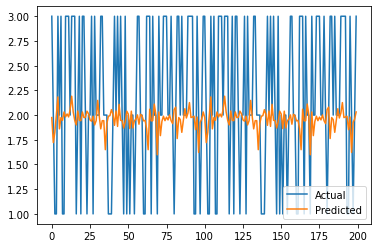

In [124]:
plt.plot(test_y, label='Actual')
plt.plot(y_test_pred.detach().numpy(), label='Predicted')
plt.legend()
plt.show()
